## Churn Prediction with PySpark

### 1. Introduction
Sparkify, a fictitious music streaming service, is created by Udacity in order to mimic the datasets generated by companies like Pandora or Spotify. Millions of users play their favorite songs through such types of services on a regular basis, either by using a premium subscription model or through a free tier that plays advertisements. Users can upgrade or downgrade their subscription plan, but also cancel it altogether at any time, so it's important to make sure the users are liking the service.

Every time a user interacts with a Sparkify app, whether listening to songs, adding them to playlists, rating them with the thumbs up/down, adding a friend, changing settings, logging out or in, user activity logs is being generated and collected. These logs can generate insights which can help business understand whether customers are happy with the service or not.

Based on the studies, it is a known fact that acquiring a customer is more expensive than retaining a customer. Therefore, in order to increase the profitability of the company, it is important to predict customers who are likely to churn - either canceling the service or downgrading the subscription level and engage with these at-risk customers in advance with incentives/discounts can help the company to prevent loss in revenue. Additionally, understanding Churn customer's unique behavior and characteristics can provide useful insights for improving the music streaming service provided by the company.

### 2. Project Overview
In the project, we would like to build a model which can predict in advance the customers who are at risk to cancel the Sparkify music streaming service based on available data which is the user's past activity and interaction logs with the service. The project is carried out with PySpark which is a python API for using Apache Spark distributed computing capabilities. The entire project in first carried out on a small subset(2/100) of the complete dataset. Models which performed well on a small dataset can further be implemented on a complete dataset with the help of the Elastic MapReduce(EMR) cluster deployed on the AWS cloud platform.

##### 2.1 Problem Statement
The goal of the project is to build a binary classifier that can accurately predict the users at risk to cancel the service at least one week in advance of their cancellation timeline. This one-week advance window is selected so that company has enough time to reengage with users at risk to churn with incentives and prevent the customer from canceling the service.

##### 2.2 Performance Metrics
Given the problem that we want to predict as much as true Churn users (high recall) and at the same time do not want to falsely predict actual Non-Churn users as Churn Users (high Precision), we will use F1 score as the optimizing and primary performance metric for the models. Other evaluation metrics including accuracy, recall, and precision are also calculated because of their better interpretability.

The further project will consist of the following main steps:
- Data Understanding and Data Cleaning
- Feature Engineering and Exploratory Data Analysis
- Modelling and Evaluation
- Results Summary
- Conclusion

In [0]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, split, udf, countDistinct, mean, to_date
from pyspark.sql.functions import sum,round
from pyspark.sql.functions import min
from pyspark.sql.functions import max
from pyspark.sql.functions import count
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import udf
import re
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, Evaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

### 3. Data Understanding and Data Cleaning :

Small subset(256mb) from complete dataset(12GB) of Sparkify user activity data is used for understanding the data and further analysis. 

**Following steps were taken to understand and clean the data:**
- Load "medium_sparkify_event_data.json" dataset
- Check the data size, columns datatypes and summary statistics to understand data and identify abnormalities
- Explore the abnormalities and clean the data
- Check and deal with duplicate rows
- Explore Null(missing) & Nan values and deal with them
- Convert timestamps to formats which can be used for further analysis and features engineering


**Based on our comprehensive data analysis, we made following observations from the data:**
- Dataset consists of 543705 rows/logs and 18 columns.
- Logs data is available for only 2 months from 1st Oct,2018 to 1st Dec,2018.
- Logs data belongs to 448 distinct users. Data with UserId as empty string mostly belongs to logged out users and therefore was deleted from our dataset.
- There is a total of 19 distinct pages a user can visit as per the data.
- There is a total of 21247 unique artists and 80292 unique songs.

In [0]:
#Load dataset

# File location and type
file_location = "/FileStore/tables/medium_sparkify_event_data.json"
file_type = "json"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# Look at head of dataset
df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
 artist| auth|firstName|gender|itemInSession|lastName| length|level| location|method| page| registration|sessionId| song|status| ts| userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
 Martin Orford|Logged In| Joseph| M| 20| Morales|597.55057| free| Corpus Christi, TX| PUT|NextSong|1532063507000| 292| Grand Designs| 200|1538352011000|"Mozilla/5.0 (Mac...| 293|
John Brown's Body|Logged In| Sawyer| M| 74| Larson|380.21179| free|Houston-The Woodl...| PUT|NextSong|1538069638000| 97| Bulls| 200|1538352025000|"Mozilla/5.0 (Mac...| 98|
 Afroman|Logged In| Maverick| M| 184|Santiago|202.37016| paid|Orlando-Kissimmee...| PUT|NextSong|1535953455000| 178|Because I Got High| 200|1538352118000|"Mozilla/5.0 (Mac...| 179|
 null|Logged In| Maverick| M| 185|Santiago| null| paid|Orlando-Kissimmee...| PUT| Logout|1535953455000| 178| null| 307|1538352119000|"Mozilla/5.0 (Mac...| 179|
 Lily Allen|Logged In| Gianna| F| 22| Campos|194.53342| paid| Mobile, AL| PUT|NextSong|1535931018000| 245|Smile (Radio Edit)| 200|1538352124000|Mozilla/5.0 (Wind...| 246|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
only showing top 5 rows

In [0]:
# Shape of dataframe
print("Shape of dataframe : ",(df.count(), len(df.columns)))

Shape of dataframe : (543705, 18)

In [0]:
# Schema of dataframe
df.printSchema()

root
-- artist: string (nullable = true)
-- auth: string (nullable = true)
-- firstName: string (nullable = true)
-- gender: string (nullable = true)
-- itemInSession: long (nullable = true)
-- lastName: string (nullable = true)
-- length: double (nullable = true)
-- level: string (nullable = true)
-- location: string (nullable = true)
-- method: string (nullable = true)
-- page: string (nullable = true)
-- registration: long (nullable = true)
-- sessionId: long (nullable = true)
-- song: string (nullable = true)
-- status: long (nullable = true)
-- ts: long (nullable = true)
-- userAgent: string (nullable = true)
-- userId: string (nullable = true)

In [0]:
# Summary Statistics
display(df.describe())

summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
count,432877,543705,528005,528005,543705,528005,432877,543705,528005,543705,543705,528005,543705,432877,543705,543705,528005,543705
mean,527.5289537712895,null,null,null,107.30629109535502,null,248.6645927800734,null,null,null,null,1.5355234148639197E12,2040.8143533717732,NaN,210.01829116892432,1.5409645412098232E12,null,60268.42669103512
stddev,966.1072451772756,null,null,null,116.72350849188156,null,98.41266955052019,null,null,null,null,3.0787254929959645E9,1434.3389310782695,NaN,31.471919021567263,1.482057144911047E9,null,109898.82324176563
min,!!!,Cancelled,Aaliyah,F,0,Abbott,0.78322,free,"Akron, OH",GET,About,1509854193000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3""",
max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1005,Wright,3024.66567,paid,"York-Hanover, PA",PUT,Upgrade,1543073874000,4808,ÃÂ¾etta Gerist ÃÂ¡ Bestu BÃÂ¦jum,404,1543622466000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0),99


Observation regarding abnormalities in data: 
- Many columns have Null values 
- Song has Nan values 
- Many columns has invalid data values 
- UserId has some empty string values

In [0]:
# Exploration of rows where userId is empty string

# Looking at users with rows with userId as empty string
df.filter('userId = ""').show(5)

# Number of rows with userId as empty string
print("Number of rows with userId as empty string",df.filter('userId = ""').groupby().count())

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
artist| auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
 null|Logged Out| null| null| 186| null| null| paid| null| GET| Home| null| 178|null| 200|1538352148000| null| |
 null|Logged Out| null| null| 187| null| null| paid| null| GET| Home| null| 178|null| 200|1538352151000| null| |
 null|Logged Out| null| null| 188| null| null| paid| null| GET| Home| null| 178|null| 200|1538352168000| null| |
 null|Logged Out| null| null| 189| null| null| paid| null| PUT|Login| null| 178|null| 307|1538352169000| null| |
 null|Logged Out| null| null| 114| null| null| free| null| GET| Home| null| 442|null| 200|1538353292000| null| |
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
only showing top 5 rows

Number of rows with userId as empty string DataFrame[count: bigint]

In [0]:
# Calculate distict UserID for 'Logged Out' auth users 
display(df.filter('auth = "Logged Out"').groupby("userID").count())

userID,count
,15606


Observation: For Logged Out users, userId is empty string

In [0]:
# Count of UserID with empty strings and non Logged Out authorization
print("Count of UserID with empty strings and non Logged Out authorization : ",df.filter('auth != "Logged Out" ').filter('userId =="" ').count())


Count of UserID with empty strings and non Logged Out authorization : 94

In [0]:
# Exploring page visited by users with empty strings
df.filter('userId =="" ').groupBy("page").count().show()

+-------------------+-----+
 page|count|
+-------------------+-----+
 Home| 8323|
 About| 829|
 Login| 6011|
 Help| 506|
 Error| 16|
 Register| 11|
Submit Registration| 4|
+-------------------+-----+

Observation : Since all the empty UserId logs does not represent any churn event and is a small fracion(3%) of overall data( 15k/500K). Additionally, most of the cells for these rows are empty therefore limited information available with these rows. Therfore, we can delete these rows.

In [0]:
# Removing UsersID with empty string
df = df.filter('userID != "" ')

In [0]:
# Exploring duplicate rows

# Total number of rows in Dataframe
print("Dataframe total row count: ",df.count())

# Total distinct number of rows
print("Distinct rows count: ",df.dropDuplicates().count())

Dataframe total row count: 528005
Distinct rows count: 528005

Observation : There are no duplicate rows.

In [0]:
# Explore nan values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 0| 1| 0| 0| 0| 0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

In [0]:
# Explore null values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
 95128| 0| 0| 0| 0| 0| 95128| 0| 0| 0| 0| 0| 0|95128| 0| 0| 0| 0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+

Observation : After deleting rows with UserID as empty string, columns ,except length and songs, all other columns does not have any null values.

In [0]:
# Number of distinct page values
print("Number of distinct page values")
df.select(countDistinct("page")).show()


Number of distinct page values
+--------------------+
count(DISTINCT page)|
+--------------------+
 19|
+--------------------+

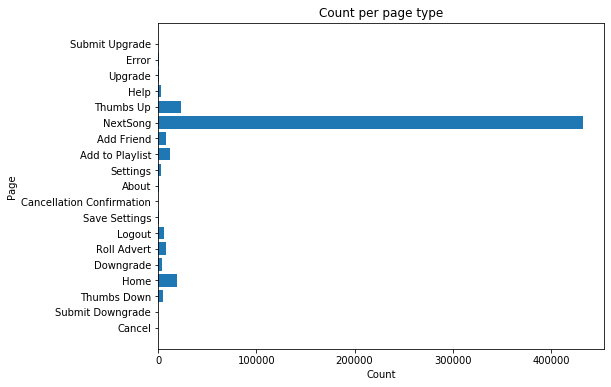

In [0]:
# Bar plot for number of records per page type
page_records = df.groupby("page").count().toPandas()

pages =  page_records["page"]
count =  page_records["count"]
plt.rcParams['figure.figsize'] = (8,6)
plt.barh(pages, count)
plt.ylabel('Page')
plt.xlabel('Count')
plt.title('Count per page type')
plt.show()

In [0]:
# Number Of records per auth type
display(df.groupby("auth").count())

auth,count
Logged In,527906
Cancelled,99


In [0]:
# Number of unique songs
print ("Number of unique songs :")
df.select(countDistinct("song")).show()

Number of unique songs :
+--------------------+
count(DISTINCT song)|
+--------------------+
 80292|
+--------------------+

In [0]:
# Number of unique Users
print("Number of unique Users:")
df.select(countDistinct("userId")).show()

Number of unique Users:
+----------------------+
count(DISTINCT userId)|
+----------------------+
 448|
+----------------------+

In [0]:
# Number of unique artists
print("Number of unique artists:")
df.select(countDistinct("artist")).show()

Number of unique artists:
+----------------------+
count(DISTINCT artist)|
+----------------------+
 21247|
+----------------------+

In [0]:
# Number Of records per level type#
display(df.groupby("level").count())


level,count
free,109961
paid,418044


In [0]:
# Adding columns for datetime and date from the timestamp columns(ts and registration)

# Function to get datetime
get_time= udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# Creating a data frame with addional columns for datetime
data = df.withColumn("datetime", get_time(df.ts))
data = data.withColumn("reg_datetime", get_time(df.registration))

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# Adding date columns
data = data.withColumn("date", to_date(col("datetime"),"yyyy-MM-dd"))
data = data.withColumn("reg_date", to_date(col("reg_datetime"),"yyyy-MM-dd"))

# Look at the original timestamp and added columns
data.select("ts","datetime","date","registration","reg_datetime","reg_date").head(10)

Out[21]: [Row(ts=1538352011000, datetime='2018-10-01 00:00:11', date=datetime.date(2018, 10, 1), registration=1532063507000, reg_datetime='2018-07-20 05:11:47', reg_date=datetime.date(2018, 7, 20)),
 Row(ts=1538352025000, datetime='2018-10-01 00:00:25', date=datetime.date(2018, 10, 1), registration=1538069638000, reg_datetime='2018-09-27 17:33:58', reg_date=datetime.date(2018, 9, 27)),
 Row(ts=1538352118000, datetime='2018-10-01 00:01:58', date=datetime.date(2018, 10, 1), registration=1535953455000, reg_datetime='2018-09-03 05:44:15', reg_date=datetime.date(2018, 9, 3)),
 Row(ts=1538352119000, datetime='2018-10-01 00:01:59', date=datetime.date(2018, 10, 1), registration=1535953455000, reg_datetime='2018-09-03 05:44:15', reg_date=datetime.date(2018, 9, 3)),
 Row(ts=1538352124000, datetime='2018-10-01 00:02:04', date=datetime.date(2018, 10, 1), registration=1535931018000, reg_datetime='2018-09-02 23:30:18', reg_date=datetime.date(2018, 9, 2)),
 Row(ts=1538352125000, datetime='2018-10-01 00:02:05', date=datetime.date(2018, 10, 1), registration=1533175710000, reg_datetime='2018-08-02 02:08:30', reg_date=datetime.date(2018, 8, 2)),
 Row(ts=1538352176000, datetime='2018-10-01 00:02:56', date=datetime.date(2018, 10, 1), registration=1535953455000, reg_datetime='2018-09-03 05:44:15', reg_date=datetime.date(2018, 9, 3)),
 Row(ts=1538352215000, datetime='2018-10-01 00:03:35', date=datetime.date(2018, 10, 1), registration=1537536032000, reg_datetime='2018-09-21 13:20:32', reg_date=datetime.date(2018, 9, 21)),
 Row(ts=1538352241000, datetime='2018-10-01 00:04:01', date=datetime.date(2018, 10, 1), registration=1537982255000, reg_datetime='2018-09-26 17:17:35', reg_date=datetime.date(2018, 9, 26)),
 Row(ts=1538352259000, datetime='2018-10-01 00:04:19', date=datetime.date(2018, 10, 1), registration=1537982255000, reg_datetime='2018-09-26 17:17:35', reg_date=datetime.date(2018, 9, 26))]

In [0]:
# Minimum and Maximum log time in data
display(data.select("datetime").agg(min("datetime"),max("datetime")))

min(datetime),max(datetime)
2018-10-01 00:00:11,2018-12-01 00:01:06


Observation : Logs data is available for 2 months from 1st Oct,2018 to 1st Dec,2018

In [0]:
# Minimum and Maximum user registration time in data
display(data.select("reg_datetime").agg(min("reg_datetime"),max("reg_datetime")))

min(reg_datetime),max(reg_datetime)
2017-11-05 03:56:33,2018-11-24 15:37:54


Observation : Just based on available logs data, on an average, life of Non Churn user are more than Churn Users.

More observations from data exploration: 
- After every "cancellation" event page there is always a "cancellation confirmation" event page
- After "downgrade" event, there is no changed observed for user for level but after every "submit downgrade" event, level changes from paid to free.

### 4. Exploratory Data Analysis:
**Based on intial exploratory data analysis, following observations were made when comparing Churn and Non-Churn users:**
- Out of total 448 users, 99 users churned based on the user activity logs data.
- Proportion of male vs female users among Churn and Non-Churn users are almost same.
- On an average, Free Users are more likely to Churn than Paid Users.
- During the available logs data, distribution of average number of songs listened, average number of sessions and average length of sessions among  both categories are significantly different.
- On an average, the Churn user age is less than non-Churn user.

**Define Churn :** 
For this project, we will be consider `Cancellation Confirmation` events as `Churn` event

In [0]:
#Adding a label column representing Churn event
Is_Churn = udf(lambda x : int(1) if x=="Cancellation Confirmation" else int(0))
data = data.withColumn("Is_Churn", Is_Churn(data.page))

display(data.head(5))

artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,datetime,reg_datetime,date,reg_date,Is_Churn
Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",293,2018-10-01 00:00:11,2018-07-20 05:11:47,2018-10-01,2018-07-20,0
John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",98,2018-10-01 00:00:25,2018-09-27 17:33:58,2018-10-01,2018-09-27,0
Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179,2018-10-01 00:01:58,2018-09-03 05:44:15,2018-10-01,2018-09-03,0
null,Logged In,Maverick,M,185,Santiago,null,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,null,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",179,2018-10-01 00:01:59,2018-09-03 05:44:15,2018-10-01,2018-09-03,0
Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,246,2018-10-01 00:02:04,2018-09-02 23:30:18,2018-10-01,2018-09-02,0


In [0]:
# Number of total unique Users
print("Total number of unique Users:")
data.select(countDistinct("userId")).show()

# Number of unique Users
print("Number of unique Churned Users:")
data.filter(data["Is_Churn"]==1).select(countDistinct("userId")).show()

Total number of unique Users:
+----------------------+
count(DISTINCT userId)|
+----------------------+
 448|
+----------------------+

Number of unique Churned Users:
+----------------------+
count(DISTINCT userId)|
+----------------------+
 99|
+----------------------+

In [0]:
# Distribution of Is_Churn amoung auth catergories
display(data.groupby("Is_Churn").pivot("auth").count())

Is_Churn,Cancelled,Logged In
0,null,527906
1,99,null


Observation : 1) During Cancellation event, the auth is always cancelled and during downgrade event the auth is always Logged in

In [0]:
# Distribution of Is_Churn amoung gender catergories
display(data.groupby("Is_Churn").pivot("gender").count())

Is_Churn,F,M
0,225348,302558
1,45,54


Observation : Distribition of gender is almost same among Churn and Non Churn events

In [0]:
# Distribution of Is_Churn amoung level catergories
display(data.groupby("Is_Churn").pivot("level").count())

Is_Churn,free,paid
0,109929,417977
1,32,67


Observation :Free users are two times more likely to churn compared to Non-Churn users

Out[29]:

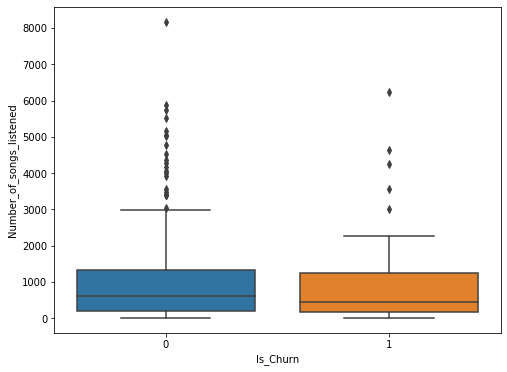

<matplotlib.axes._subplots.AxesSubplot at 0x7fa29773d590>

In [0]:
# Average number of songs listened by Churn and Non Churn Users during the available logs data
from pyspark.sql.functions import count
import seaborn as sns
Number_of_songs_per_user = data.groupBy("userId").agg(count("song").alias("Number_of_songs_listened"),max("Is_Churn").alias("Is_Churn"))
dataframe1 = Number_of_songs_per_user.toPandas()

# Plot number of songs listened by Churn and Non Churn Users during the available logs data
sns.boxplot( x= dataframe1["Is_Churn"], y=dataframe1["Number_of_songs_listened"] )

Out[30]:

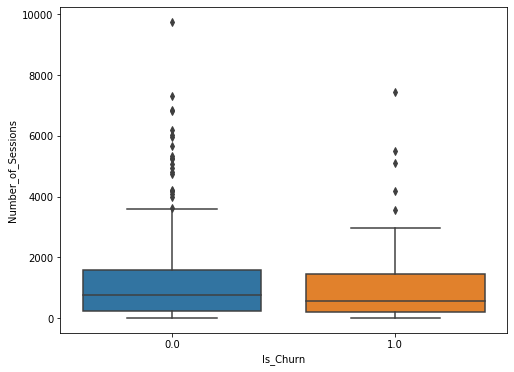

<matplotlib.axes._subplots.AxesSubplot at 0x7fa29406be50>

In [0]:
#SessionID_exploration

# Average Numbers of sessions with Churn and Non Churn Users during the available logs data
SessionID_exploration = data.groupBy("userID").agg(count("sessionId").alias("Number_of_Sessions"),sum("Is_Churn").alias("Is_Churn"))
dataframe2 = SessionID_exploration.toPandas()

# Plot Numbers of sessions with Churn and Non Churn Users during the available logs data
sns.boxplot( x= dataframe2["Is_Churn"], y=dataframe2["Number_of_Sessions"] )


Out[31]:

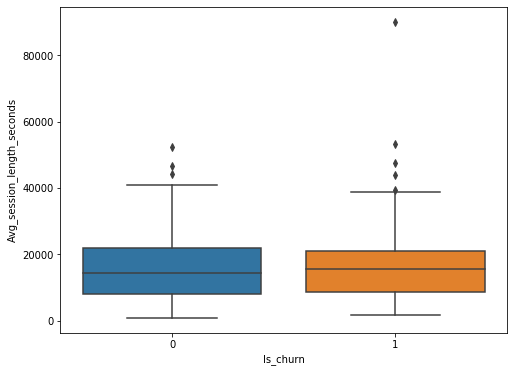

<matplotlib.axes._subplots.AxesSubplot at 0x7fa2846a2c10>

In [0]:
# Average Session length with Churn and Non Churn Users during the available logs data
session_data = data.groupBy("userID","sessionId").agg(max("Is_Churn").alias("Is_churn"),max("datetime").alias("max_time"),min("datetime").alias("min_time"))
session_data =session_data.withColumn("Session_length",(unix_timestamp("max_time")-unix_timestamp("min_time")) )
dataframe3 = session_data.groupBy("userID").agg(max("Is_churn").alias("Is_churn"),mean("Session_length").alias("Avg_session_length_seconds"))
dataframe3 = dataframe3.toPandas()

# Plot Average Session length with Churn and Non Churn Users during the available logs data
sns.boxplot( x= dataframe3["Is_churn"], y=dataframe3["Avg_session_length_seconds"] )

Out[32]:

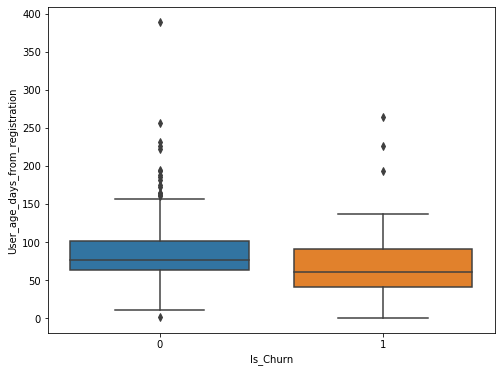

<matplotlib.axes._subplots.AxesSubplot at 0x7fa27f4f5ed0>

In [0]:
# Visualising Users age from the registration
from pyspark.sql.functions import col, max
from pyspark.sql.functions import datediff,col
user_age = data.groupBy("userId").agg(max("Is_Churn").alias("Is_Churn"),min("reg_date").alias("reg_time"),max("date").alias("max_time"))
dataframe4 = user_age.withColumn("User_age_days_from_registration", datediff(col("max_time"),col("reg_time")).alias("user_age_days"))

dataframe4 = dataframe4.toPandas()

# Plot Users age from the registration
sns.boxplot( x= dataframe4["Is_Churn"], y=dataframe4["User_age_days_from_registration"] )

Observation : On an average, Churn users have lower age than Non-Churn users

Out[33]:

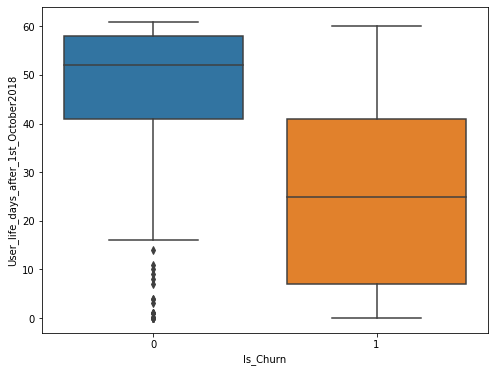

<matplotlib.axes._subplots.AxesSubplot at 0x7fa27e1c91d0>

In [0]:
# Visualising Users life within our available logs timing data
from pyspark.sql.functions import col, max
from pyspark.sql.functions import datediff,col
user_life = data.groupBy("userId").agg(max("Is_Churn").alias("Is_Churn"),min("date").alias("min_time"),max("date").alias("max_time"))
dataframe5 = user_life.withColumn("User_life_days_after_1st_October2018", datediff(col("max_time"),col("min_time")).alias("user_life_days"))

dataframe5 = dataframe5.toPandas()

# Plot Users life within our available logs timing data
sns.boxplot( x= dataframe5["Is_Churn"], y=dataframe5["User_life_days_after_1st_October2018"] )

Observation : There are users who registered before the timing of log data is  also available with us.

###5. Feature Engineering: 
Based on initial analysis regarding users' age, the feature needs to be per unit time or a proportion of the user's total activity, since there are users with different life span lengths. Based on our problem definition, since we want to predict 7 days in advance of the user's Churn event, therefore for each user's last 7 days activity log data will not be available for features generation. Also, users with ages less than 7days will be removed as they did not fit in our problem definition scenario.

** 5.1 We will be considering following features**:

User demographic features : 
- User age from registration time stamp, Level - Free/Paid, Gender - Male/Female

User behavior and activity features:
-  Average features per day over complete available data for each user  : Number of songs played, Length of songs played, Number of sessions
-  Fraction pages visited (Fraction of total activity) : 
  - Negative Impact features: Error, Help, Roll Advert, Settings, Submit downgrade, Thumbs down
  - Positive Impact features: Add friend, Add to Playlist, Submit upgrade, Thumbs up

In [0]:
# Filtering relevant data for our feature engineering
data_relevant = data.select("userId","ts","datetime","date","registration","reg_datetime","reg_date","sessionId","page","song","length","level","Gender","Is_Churn").sort(col("userId"),col("date").asc())

In [0]:
# Rename Is_Churn Column
data_relevant = data_relevant.withColumnRenamed("Is_Churn", "Is_Churn(t)")

** Adding user's Total Age and user's Available Log time as features:**

In [0]:
#function for converting days to seconds
days = lambda x: x * 86400

# Given we want to predict 7 days in advance of the Churn event, therefore the defining the users logs data available window
windowval_available = (Window.partitionBy("userId").orderBy(col("ts")/1000).rangeBetween(Window.unboundedPreceding, -days(7)))

max_date = max("date").over(windowval_available)
min_date = min("date").over(windowval_available)
reg_date = min("reg_date").over(windowval_available)

# Addding User age in days as feature
data_relevant = data_relevant.withColumn("age_days(t_7)",(datediff(max_date,reg_date))+1)

# Addding available log time in days as feature                              
data_relevant = data_relevant.withColumn("available_log_days(t_7)",(datediff(max_date,min_date))+1)

**Adding Average per day features**

In [0]:
# Add average number of songs played per day until the time the user was last active on app(before 7 day from current time)
data_relevant = data_relevant.withColumn("avg_num_songs_per_day(t_7)", round((count("song").over(windowval_available))/col("available_log_days(t_7)"),4))

# Add Average Length of songs played(music time) per day until the time the user was last active  on app(before 7 day from current time)
data_relevant = data_relevant.withColumn("avg_length_secs_per_day(t_7)", round((sum("length").over(windowval_available))/col("available_log_days(t_7)"),4))

# Add Number of sessions per day until the time the user was last active  on app(before 7 day from current time)
data_relevant = data_relevant.withColumn("avg_number_sessions_per_day(t_7)", round(F.size(F.collect_set("sessionID").over(windowval_available))/col("available_log_days(t_7)"),4))


**Adding Negative Features**

In [0]:
# Adding fraction submit downgrade activity during available logdata as feature
func_submit_downgrade = udf(lambda page : int(page == 'Submit Downgrade'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_submit_downgrade(t_7)",round((sum(func_submit_downgrade(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ))

# Adding fraction error downgrade activity during available logdata as feature
func_error = udf(lambda page : int(page == 'Error'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_error(t_7)",round((sum(func_error(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction help downgrade activity during available logdata as feature
func_help = udf(lambda page : int(page == 'Help'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_help(t_7)",round((sum(func_help(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Roll Advert activity during available logdata as feature
func_Roll_Advert = udf(lambda page : int(page == 'Roll Advert'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Roll_Advert(t_7)",round((sum(func_Roll_Advert(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Save Settings activity during available logdata as feature
func_Save_Settings = udf(lambda page : int(page == 'Save Settings'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Save_Settings(t_7)",round((sum(func_Save_Settings(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Thumbs Down activity during available logdata as feature
func_Thumbs_Down = udf(lambda page : int(page == 'Thumbs Down'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Thumbs_Down(t_7)",round((sum(func_Thumbs_Down(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )


**Addding Positive features**

In [0]:
# Adding fraction Submit Upgrade activity during available logdata as feature
func_Submit_Upgrade = udf(lambda page : int(page == 'Submit Upgrade'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Submit_Upgrade(t_7)",round((sum(func_Submit_Upgrade(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Add Friend activity during available logdata as feature
func_Add_Friend = udf(lambda page : int(page == 'Add Friend'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Add_Friend(t_7)",round((sum(func_Add_Friend(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Add to Playlist activity during available logdata as feature
func_Add_to_Playlist= udf(lambda page : int(page == 'Add to Playlist'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Add_to_Playlist(t_7)",round((sum(func_Add_to_Playlist(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )

# Adding fraction Add to Playlist activity during available logdata as feature
func_Thumbs_Up= udf(lambda page : int(page == 'Thumbs Up'), IntegerType())
data_relevant = data_relevant.withColumn("fraction_Thumbs_Up(t_7)",round((sum(func_Thumbs_Up(col("page"))).over(windowval_available))/(count(col("page")).over(windowval_available)),4 ) )


** Adding Is_paid and Is_Male binary features**

In [0]:
# Add Is_paid as a feature
func_paid = udf(lambda level : int(level == 'paid'), IntegerType())
data_relevant = data_relevant.withColumn("Is_paid",func_paid(col("level")))

# Add Is_Male as a feature
func_male = udf(lambda Gender : int(Gender == 'M'), IntegerType())
data_relevant = data_relevant.withColumn("Is_Male",func_male(col("Gender")))

** Filtering data for each user containing only latest time data so that for each user we have only one row.**

In [0]:
# Ranking data on time so that for every customer only latest time datapoints can be used
data_relevant = data_relevant.withColumn("dense_rank",F.dense_rank().over(Window.partitionBy("userId").orderBy(col("ts").desc())))

# Filtering data at the latest time for every user
data_relevant = data_relevant.where("dense_rank ==1")

**Removing Users with age less than 7 days**

In [0]:
# Checking Null values in data
display(data_relevant.select([count(when(col(c).isNull(), c)).alias(c) for c in data_relevant.columns]))

userId,ts,datetime,date,registration,reg_datetime,reg_date,sessionId,page,song,length,level,Gender,Is_Churn(t),age_days(t_7),available_log_days(t_7),avg_num_songs_per_day(t_7),avg_length_secs_per_day(t_7),avg_number_sessions_per_day(t_7),fraction_submit_downgrade(t_7),fraction_error(t_7),fraction_help(t_7),fraction_Roll_Advert(t_7),fraction_Save_Settings(t_7),fraction_Thumbs_Down(t_7),fraction_Submit_Upgrade(t_7),fraction_Add_Friend(t_7),fraction_Add_to_Playlist(t_7),fraction_Thumbs_Up(t_7),Is_paid,Is_Male,dense_rank
0,0,0,0,0,0,0,0,0,354,354,0,0,0,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,0,0,0


In [0]:
# Distribution of Churn vs Non Churn users among users life less than 7 days
display(data_relevant.where(data_relevant['age_days(t_7)'].isNull()).groupBy("Is_Churn(t)").agg(count("userId")))

Is_Churn(t),count(userId)
0,20
1,24


In [0]:
# Removing users with age less than 7 days
data_relevant = data_relevant.filter(data_relevant['age_days(t_7)'].isNotNull())

# Confirming Null values in data
display(data_relevant.select([count(when(col(c).isNull(), c)).alias(c) for c in data_relevant.columns]))

userId,ts,datetime,date,registration,reg_datetime,reg_date,sessionId,page,song,length,level,Gender,Is_Churn(t),age_days(t_7),available_log_days(t_7),avg_num_songs_per_day(t_7),avg_length_secs_per_day(t_7),avg_number_sessions_per_day(t_7),fraction_submit_downgrade(t_7),fraction_error(t_7),fraction_help(t_7),fraction_Roll_Advert(t_7),fraction_Save_Settings(t_7),fraction_Thumbs_Down(t_7),fraction_Submit_Upgrade(t_7),fraction_Add_Friend(t_7),fraction_Add_to_Playlist(t_7),fraction_Thumbs_Up(t_7),Is_paid,Is_Male,dense_rank
0,0,0,0,0,0,0,0,0,315,315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Prepare final featured data
featured_data = data_relevant.drop("userId","ts","datetime","date","registration","reg_datetime","reg_date",\
                                  "sessionId","page","song","length","level","Gender","Is_SubmitDowngrade","available_log_days(t_7)","dense_rank")

In [0]:
# Shape of dataset
print("Shape of dataset : ",(featured_data.count(), len(featured_data.columns)))

Shape of dataset : (410, 17)

In [0]:
featured_data.select(countDistinct("userId")).show()

###5.2 Features Exploration

**Following obervations were made on exploring features** :
- ** Correlation heat map ** :
  - Avg_num_songs_per_day(t_7) & Avg_num_secs_per_day(t_7) are almost completely positively correlated. Thesefore we can remove Avg_num_secs_per_day(t_7) keeping only among these two variables.
  - Is_paid and Fraction_roll_advert(t_7) are negatively correlated as advertisements are shown only to free subscription users.
  
- ** Distribution density plots** :
  - On average age of non Churn users is more than Churn users
  - On average churned users played more songs,listen more length, have more sessions per day
  - On average churned users had more thumbs down and thumbs up than non Churn users
  - On average roll advertisements are more among Churn users
  - On average churned users has more fraction add friend activity than non Churn users

Out[47]:

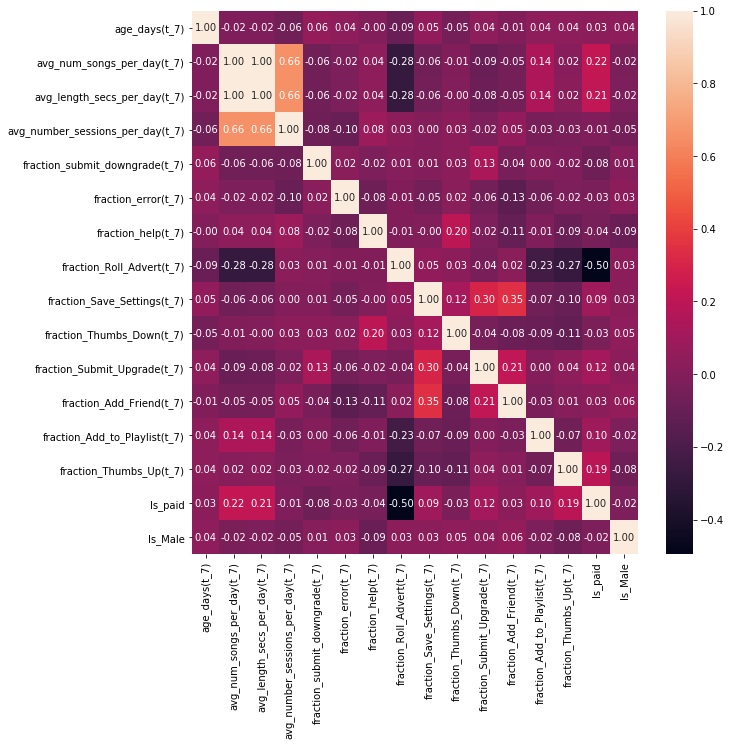

<matplotlib.axes._subplots.AxesSubplot at 0x7fa29762ea50>

In [0]:
# Correlation heat map for features
import seaborn as sns

pd_featured_data = featured_data.toPandas()

fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(pd_featured_data.corr(),annot=True,fmt =".2f")

In [0]:
# Remove Avg_num_secs_per_day(t_7) variable
featured_data = featured_data.drop("avg_length_secs_per_day(t_7)")

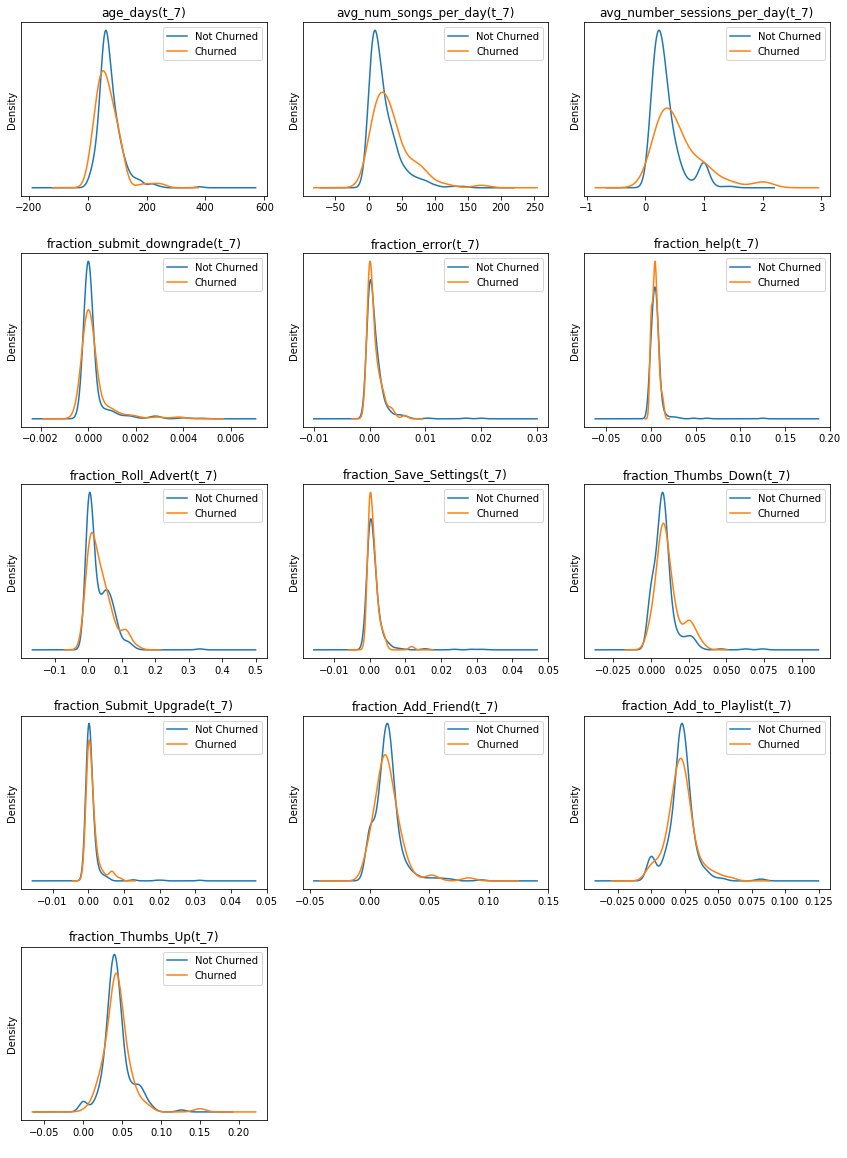

In [0]:
# Plot density plots for Churn and Non-Churn User
pd_featured_data = featured_data.toPandas()

# Numerical features
numeric_columns = ['age_days(t_7)', 'avg_num_songs_per_day(t_7)', 'avg_number_sessions_per_day(t_7)', 'fraction_submit_downgrade(t_7)',\
                   'fraction_error(t_7)', 'fraction_help(t_7)', 'fraction_Roll_Advert(t_7)', 'fraction_Save_Settings(t_7)', 'fraction_Thumbs_Down(t_7)', 
                   'fraction_Submit_Upgrade(t_7)', 'fraction_Add_Friend(t_7)', 'fraction_Add_to_Playlist(t_7)', 'fraction_Thumbs_Up(t_7)']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(numeric_columns)):
  plt.subplot(5,3,i+1)
  plt.tight_layout()
  pd_featured_data[pd_featured_data['Is_Churn(t)'] == '0'][numeric_columns[i]].plot(kind ="kde")
  pd_featured_data[pd_featured_data['Is_Churn(t)'] == '1'][numeric_columns[i]].plot(kind ="kde")
  plt.legend(['Not Churned','Churned'])
  plt.title(numeric_columns[i]);
  plt.xlabel(" ");
  plt.yticks([]);
plt.show()

###6. Modeling and Evaluation

In this section, we have used the **Spark ML capabilities**.We started with the simplicity of Logistic regression and then further implemented tree-based models including Random Forest and Gradient Boosted trees which can potentially improve the performance by reducing the variance. 

For every binary classification model, we have carried out following steps:
- Step 1 : **Build pipeline**
  - Vectorised the Numeric features with VectorAssembler
  - Standardise the Numeric Features
  - Combine the binary and numeric featurs and featurise them with VectorAssembler
  - Select the Binary classifier
- Step 2 : Define **Grid Search Paramgrid** and do **3-fold Cross-Validation** with **F1 as optimising metric** to find best model parameters
- Step 3 : **Fit the model** wih best parameters on train data
- Step 4 : With the trained fit model, **predict** on test data
- Step 5 : **Evaluate model performace** - F1, Recall, Precision, Accuracy
- Step 6 : Visualise **features Importance** for the model

In [0]:
# date prep for modelling
from pyspark.sql.types import IntegerType
featured_data = featured_data.withColumnRenamed("Is_Churn(t)","label")
featured_data = featured_data.withColumn("label", featured_data["label"].cast(IntegerType()))

**Train-Test split of dataset**

In [0]:
#Split train/test data
train, test = featured_data.randomSplit([0.8, 0.2], seed=42)

train_size = train.count()
churn_labels_in_train = train.filter(col('label') == 1).count() / train_size
print("train_size :",train_size,", churn_labels_fraction_in_train :",churn_labels_in_train)

test_size = test.count()
churn_labels_in_train =  test.filter(col('label') == 1).count() / test_size
print("test_size :",test_size,", churn_labels_fraction_in_test :",churn_labels_in_train)

train_size : 329 , churn_labels_fraction_in_train : 0.17325227963525835
test_size : 81 , churn_labels_fraction_in_test : 0.2222222222222222

In [0]:
# Numberic features list
numeric_columns = ['age_days(t_7)', 'avg_num_songs_per_day(t_7)', 'avg_number_sessions_per_day(t_7)', 'fraction_submit_downgrade(t_7)',\
                   'fraction_error(t_7)', 'fraction_help(t_7)', 'fraction_Roll_Advert(t_7)', 'fraction_Save_Settings(t_7)', 'fraction_Thumbs_Down(t_7)',\
                   'fraction_Submit_Upgrade(t_7)', 'fraction_Add_Friend(t_7)', 'fraction_Add_to_Playlist(t_7)', 'fraction_Thumbs_Up(t_7)']


# Combining multiple numerical features using VectorAssembler
numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol = "numericvectorized")

# Standardizing numerical features
scaler = StandardScaler(inputCol = "numericvectorized", outputCol = "numericscaled", withStd = True, withMean = True)

# Adding the two binary features
binary_columns = ['Is_paid', 'Is_Male']
total_assembler = VectorAssembler(inputCols = binary_columns + ["numericscaled"], outputCol = "features")

In [0]:
#defining fit model for the pipeline
def fit_model(model, paramGrid = None):
  """ build the pipeline, fit the model on train with best crossvalidated model\
  and predict on test data
  
  Args:
    model: model estimator
    
  Returns:
    fitmodel: best fitted model on train data
    results: prediction results on test data
  """
  # define pipeline
  pipeline = Pipeline(stages=[numeric_assembler, scaler, total_assembler, model])

  # cross validate on parameter and fit the best model on train data
  if paramGrid != None:
      crossval = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=paramGrid,
                        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                        numFolds=3)
      fitmodel = crossval.fit(train)
  else:
      fitmodel = pipeline.fit(train)
  
  #predict on test data
  results = fitmodel.transform(test)

  return fitmodel, results

In [0]:
# defining function for calculating evaluation metrics
def evaluation(results):
  """ calculate accuracy,precision, recall, f1 metrics
  
  Args:
    results: model prediction results on test data
    
  Returns:
    (accuracy,precision, recall, f1) : evaluation metrics
  """

  dataset = results.select(['prediction', 'label'])
  
  tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
  fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
  tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
  fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
  total = dataset.count()

  # Add epsilon to prevent division by zero
  accuracy = (tp+tn)/(total)
  precision = tp / (tp + fp + 0.00001)
  recall = tp / (tp + fn + 0.00001)
  f1 = 2 * precision * recall / (precision + recall + 0.00001)

  return(accuracy,precision, recall, f1)

**Logistic Regression Modeling**

In [0]:
# Logistic Regression with no weights of classes considered

# define model
lr = LogisticRegression(maxIter=10)

# define parametes grid
lr_paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.0,0.5,1]).addGrid(lr.threshold,[0.5]).build()

# fit model pipeline
lrmodel, lrresults = fit_model(lr, paramGrid = lr_paramGrid)

# getting best model based on grid search
best_model_index = lrmodel.avgMetrics.index(np.max(lrmodel.avgMetrics))
best_model_param = lr_paramGrid[best_model_index]
print(best_model_param)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
{Param(parent='LogisticRegression_e4326d216e68', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_e4326d216e68', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.5}

In [0]:
# Getting best Evaluation metrics
print("LogisticRegression without class weights - accuracy,precision, recall, f1 :", evaluation(lrresults))

LogisticRegression without class weights - accuracy,precision, recall, f1 : (0.7777777777777778, 0.0, 0.0, 0.0)

**Logistic Regression with Class weights for imbalance treatment**

In [0]:
# Get weighted column to deal with imbalance of data catergories
balancingRatio = train.filter(col('label') == 1).count() / train.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())
train = train.withColumn("classWeightCol", calculateWeights('label'))

In [0]:
# Logistic Regression with weights of classes considered

# define model
lr_w = LogisticRegression(maxIter=10,weightCol = 'classWeightCol')

# define parametes grid
lr_w_paramGrid = ParamGridBuilder().addGrid(lr_w.regParam,[0.0,0.5,1]).addGrid(lr_w.threshold,[0.5]).build()

# fit model pipeline
lr_w_model, lr_w_results = fit_model(lr_w, paramGrid = lr_w_paramGrid)

# getting best model based on grid search
lr_w_best_model_index = lr_w_model.avgMetrics.index(np.max(lr_w_model.avgMetrics))
lr_w_best_model_param = lr_w_paramGrid[lr_w_best_model_index]
print(lr_w_best_model_param)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
{Param(parent='LogisticRegression_54d37f44ec25', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_54d37f44ec25', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.5}

In [0]:
# Getting best Evaluation metrics
print("LogisticRegression with class weights - accuracy,precision, recall, f1 :", evaluation(lr_w_results))

LogisticRegression with class weights - accuracy,precision, recall, f1 : (0.7037037037037037, 0.3749998437500651, 0.49999972222237654, 0.42856632658658833)

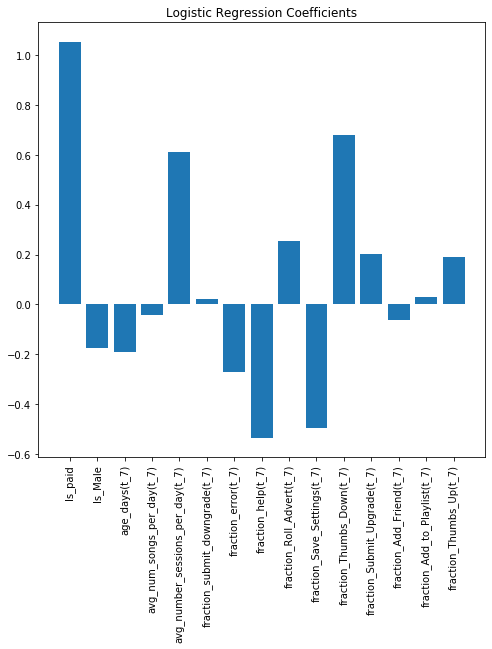

In [0]:
# List of features
list_feats =  binary_columns + numeric_columns

# model features coefficients
lr_w_corr = lr_w_model.bestModel.stages[-1].coefficients

# plot logistic regression coefficients
plt.rcParams['figure.figsize'] = (8,8)
plt.bar(list_feats,lr_w_corr)
plt.xticks(rotation='vertical')
plt.title('Logistic Regression Coefficients')
plt.show()

**Random Forest Modeling**

In [0]:
# Random Forest with no weights of classes considered

# define model
rf_1 = RandomForestClassifier()

# define parametes grid
rf_paramGrid_1 = ParamGridBuilder().addGrid(rf_1.maxDepth,[5,10]).addGrid(rf_1.numTrees,[20,50]).addGrid(rf_1.featureSubsetStrategy,["sqrt","onethird"]).build()

# fit model pipeline
rfmodel_1, rfresults_1 = fit_model(rf_1, paramGrid = rf_paramGrid_1)

# getting best model based on grid search
best_model_index_1 = rfmodel_1.avgMetrics.index(np.max(rfmodel_1.avgMetrics))
best_model_param_1 = rf_paramGrid[best_model_index_1]
print(best_model_param_1)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
{Param(parent='RandomForestClassifier_efda3fb597e5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_efda3fb597e5', name='numTrees', doc='Number of trees to train (>= 1).'): 20, Param(parent='RandomForestClassifier_efda3fb597e5', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'onethird'}

In [0]:
# Getting best Evaluation metrics
print("Random Forest - accuracy,precision, recall, f1 :", evaluation(rfresults_1))

Random Forest - accuracy,precision, recall, f1 : (0.7654320987654321, 0.3333322222259259, 0.055555524691375174, 0.09523555561375531)

**Random Forest Modeling with Class weights for imbalance treatment**

In [0]:
# Random Forest with no weights of classes considered

# define model
rf = RandomForestClassifier(weightCol = 'classWeightCol')

# define parametes grid
rf_paramGrid = ParamGridBuilder().addGrid(rf.maxDepth,[5,10]).addGrid(rf.numTrees,[20,50]).addGrid(rf.featureSubsetStrategy,["sqrt","onethird"]).build()

# fit model pipeline
rfmodel, rfresults = fit_model(rf, paramGrid = rf_paramGrid)

# getting best model based on grid search
best_model_index = rfmodel.avgMetrics.index(np.max(rfmodel.avgMetrics))
best_model_param = rf_paramGrid[best_model_index]
print(best_model_param)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
{Param(parent='RandomForestClassifier_efda3fb597e5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='RandomForestClassifier_efda3fb597e5', name='numTrees', doc='Number of trees to train (>= 1).'): 20, Param(parent='RandomForestClassifier_efda3fb597e5', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'sqrt'}

In [0]:
# Look at rfresults
rfresults.select("label","prediction","probability").show(5)

+-----+----------+--------------------+
label|prediction| probability|
+-----+----------+--------------------+
 0| 0.0|[0.87118367916965...|
 0| 0.0|[0.74902279490350...|
 0| 0.0|[0.70199298122352...|
 0| 0.0|[0.73420078194440...|
 0| 0.0|[0.89137572792350...|
+-----+----------+--------------------+
only showing top 5 rows

In [0]:
# Getting best Evaluation metrics
print("Random Forest - accuracy,precision, recall, f1 :", evaluation(rfresults))

Random Forest - accuracy,precision, recall, f1 : (0.8024691358024691, 0.6249992187509766, 0.27777762345687584, 0.38461082844864775)

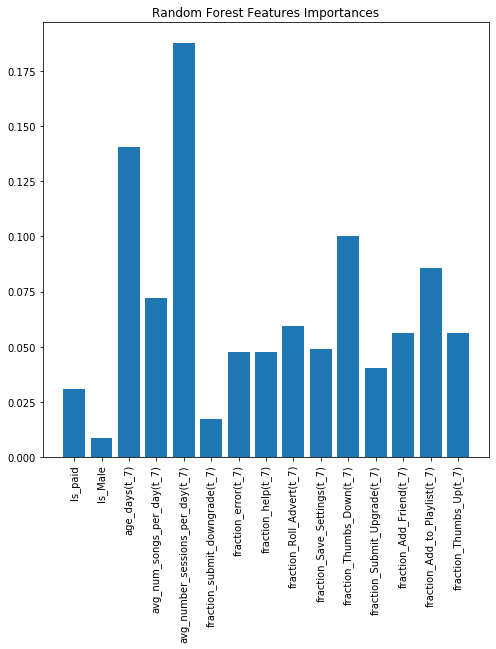

In [0]:
# Extract feature importance from rfmodel
featImportances = np.array(rfmodel.bestModel.stages[-1].featureImportances)

# List of features
list_feats =  binary_columns + numeric_columns

# plot Random Forest coefficients
plt.bar(list_feats,featImportances)
plt.xticks(rotation='vertical')
plt.title('Random Forest Features Importances')
plt.show()

**Gradient Boosting trees Modeling **

In [0]:
# GBT with no weights of classes considered

# define model
gb = GBTClassifier()

# define parametes grid
gb_paramGrid = ParamGridBuilder().addGrid(gb.maxDepth,[2,3]).addGrid(gb.maxIter,[20,50]).build()

# fit model pipeline
gbmodel, gbresults = fit_model(gb, paramGrid = gb_paramGrid)

# getting best model based on grid search
best_model_index = gbmodel.avgMetrics.index(np.max(gbmodel.avgMetrics))
best_model_param = gb_paramGrid[best_model_index]
print(best_model_param)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
{Param(parent='GBTClassifier_922e8fdaf17b', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_922e8fdaf17b', name='maxIter', doc='max number of iterations (>= 0).'): 50}

In [0]:
# Getting best Evaluation metrics
print(" Gradient Boosting Trees - accuracy,precision, recall, f1 :", evaluation(gbresults))

Gradient Boosting Trees - accuracy,precision, recall, f1 : (0.8024691358024691, 0.7499981250046875, 0.16666657407412552, 0.2727240496157774)

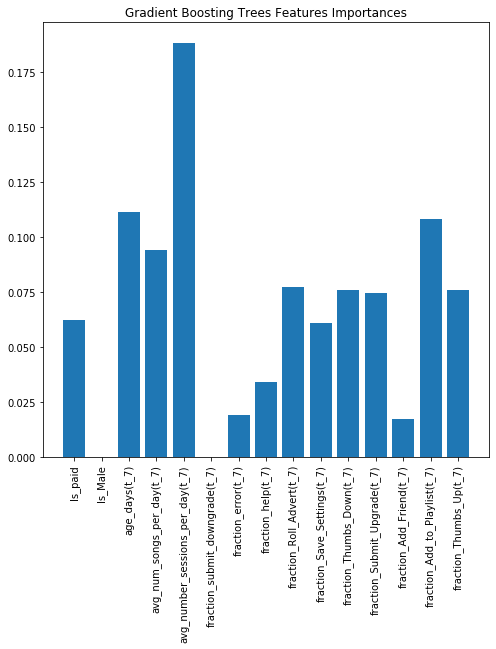

In [0]:
# Extract feature importance from gbmodel
featImportances = np.array(gbmodel.bestModel.stages[-1].featureImportances)

# List of features
list_feats =  binary_columns + numeric_columns

# plot logistic regression coefficients
plt.bar(list_feats,featImportances)
plt.xticks(rotation='vertical')
plt.title('Gradient Boosting Trees Features Importances')
plt.show()

###7. Results Summary:
- Based on the above modeling, we searched for the models with the best parameters with the help of grid search cross-validation and further trained these models on train data and predicted the customer churn labels for test data. - While comparing the evaluation metrics, we can clearly see that f1 score of the logistic regression and random forest improved significantly when we considered the weight of classes to deal with the imbalance present in our data. 
- Among the tree-based models, Random forest with considering clas weights performed better than gradient boostin based on the parameters we have considered until now. Another area for improvement we have not considered until now is tuning with probability threshold. The default threshold of 0.5 is considered right now to calculating F1 scores for all considered models. 
- Different models are suggesting different importances for different features. Looking at feature importance plots, some of the important features are the average number of sessions per day, the fraction of submit downgrade activity, and user age.
- Among all the models builds on this small dataset, we see that logistic regression when considered with class weights performed best. One of the probable reasons for overall weak F1 performance among models can be because of the size of data considered. Modeling with a larger dataset can stabilize and can show the actual performance of the models.

In [0]:
# Make the results summary for the models considered.
results_summary = dict()
results_summary["Classifier"] = ["Logistic Regression","Random Forest", "Gradient Boosted Tree","Logistic Regression with class weights","Random Forest with class weights"]
results_summary["Parameters"] = [("regParam :0,threshold :0.5"),("maxDepth:10, numTrees:20, featureSubsetStrategy:onethird"),("maxDepth :2, maxIter:50"),("regParam :0,threshold :0.5"),("maxDepth:5, numTrees:20, featureSubsetStrategy:sqrt")]
results_summary["F1"] = [0.00,0.09,0.27,0.42,0.38]
results_summary["Accuracy"] = [0.77,0.76,0.80,0.70,0.80]
results_summary = pd.DataFrame(results_summary)
display(results_summary)


Classifier,Parameters,F1,Accuracy
Logistic Regression,"regParam :0,threshold :0.5",0.0,0.77
Random Forest,"maxDepth:10, numTrees:20, featureSubsetStrategy:onethird",0.09,0.76
Gradient Boosted Tree,"maxDepth :2, maxIter:50",0.27,0.8
Logistic Regression with class weights,"regParam :0,threshold :0.5",0.42,0.7
Random Forest with class weights,"maxDepth:5, numTrees:20, featureSubsetStrategy:sqrt",0.38,0.8


###8. Conclusion

**8.1 Reflection**:

In this project, we started with analyzing the small subset users' activity logs data with Sparkify music streaming service and finally able to build binary classifiers which can predict the customers who are likely to churn one week in advance of the probable churn event timing. In a real-world production scenario, as soon as users activity logs are generated and add to their history, our model can alert the company if the customer is at risk to leave the music service based on their past commutative behavior and allow the company to engage and target the specific customers with incentives to prevent the customer churn.

The most interesting and challenging of the project was engineering the features which can represent the user's past behavior activity and at the same time which might lead to identifying differences between churn and non-churn users. Another creative part of this problem was how you can keep the real-world business problem scenario in mind while defining your problem statement.

**8.2 Future scope of work and Potential improvements**:

There is definitely the scope for further work and potential improvements in many aspects of the problem. Some of these are:
- Data Exploration: We did not explore the location of users' logs activity data which might provide an interesting insight to the company providing and can help them to focus their efforts specific to user locations.
- Feature Engineering: We considered user aggregated activity features and demographic features but we did not consider features representing the dynamic changes in users' behaviors over time. Features representing tend behavior of user activity can be helpful in differentiating Churn and Non-Churn users.
- Modeling: As seen in the results summary, the use of probability threshold can be further explored with models probability predictions, which can further improve the model f1 performance.
- Increasing Dataset size: Until now we have trained our models on a subset of the complete dataset which might not be representing the actual population distribution and therefore might not be providing the actual performance. For confirming the robustness of these models, these models need to be trained, validated and tested on a larger dataset.

### 9. References
- https://www.kdnuggets.com/2019/05/churn-prediction-machine-learning.html